# hdfDB: Using HDF5 file(s) as a database

HDF files can be considered databases. What is missing in the standard `h5py` implementation are query functions. This chapter will take you through everything you need to know to find data within one or more HDF5 files based on attributes. The explanation will be conducted using practical examples.

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox.database import FileDB
from h5rdmtoolbox import tutorial

h5tbx.use(None)

Failed to import module h5tbx


using("h5py")

## Searching within a single file

Imagine a large, nested HDF5 file contains data from a fluid experiment. Some datasets represent pressure data, others are velocity datasets. With future reuse in mind, we assigned the attribute "standard_name" to the datasets during data creation. We now want ... 

 ... **to find all datasets with attribute "standard_name" equal to "velocity"**

The example file is provided by the tutorial module:

In [2]:
filename = tutorial.generate_fluid_hdf_file()
h5tbx.dump(filename)

The database we are going to use is the `GroupDB`. It takes an opened HDF5 group as input. As we know from the [notebook "first steps"](./firstSteps.ipynb), using `find` or `find_one` will return what we are searchng for.

Since we are looking for *all* velocity datasets, we will choose `find`:

In [3]:
db = FileDB(filename)
res = db.find({'standard_name': 'velocity'})

for r in res:
    print(r.name)

/velocity
/group1/velocity
/group2/velocity


**So how does the query work?**

This is going to get a bit technical. Bear with me, the example code below will make it clearer.

Note, that the input for the `find()` and `find_one()` methods expect arguments similar to the `pymongo` syntax. If you are familiar to it, usage will be very natural for you. If not, here's how the filter request is built up:

The methods expect a dictionary in the following way:

  `find({<kw_pr_prop1>: <value_or_operator1>, <kw_pr_prop1>: <value_or_operator2>, ...}, <object_filter>)`

The first argument is the main filter argument. It is a dictionary, containing one or multiple keyword-value-pairs:
 - The simplest filter argument is the one we used above, which searches for the exact match of an attribute (in our case "standard_name") and its value (in our case "velocity").
 - To match a HDF5 dataset or group property, like the HDF5 internal path (`.name`) use "\\$name" for the keyword (mind the dollar sign!)
 - Instead of the value, we could also provide an "operator", e.g. `{$eq: "velocity"}`. An operator always starts with a "`$`"-sign. The above function called would look like this:<br>`db.find({'standard_name': {'$eq': 'velocity'}})`
 - We could have searched for HDF5 objects, which require multiple attribute key-value pairs to match. E.g. we could have queried for the units attribute, too:<br>
 `db.find({'standard_name': 'velocity', 'units': 'm/s'})`

With the *second* argument (*<object_filter>*) we can select, whether we want to search for datasets or groups only, or for both (default). In our query, we were looking for datasets only, so a better query would have been the following:<br>
`db.find({'standard_name': 'velocity', 'units': 'm/s'}, 'dataset')`

## Example queries

We already learned how to find objects that match one or multiple key value pairs of attribute data. Sometimes, we want to perform more sophisticated queries, e.g. we would like to ... 
1. ... find all datasets that have a certain attribute key (the value is not of interest),
2. ... find attributes where the string matches a regex expression,
3. ... find attributes with numeric values that are greater than, lower than, ... a certain value,
4. ... find attributes, which match our own operator

The following subsections show how it is done:

### 1. Operator: Exists:

Find objects which have the attribute "units"

In [4]:
db = FileDB(filename)
results = db.find({'units': {'$exists': True}})
for r in results:
    print(r.name)

/pressure1
/group2/velocity
/group2/pressure2
/group1/velocity
/velocity
/group2/z


Find objects which *don't* have the attribute "units"

In [5]:
db = FileDB(filename)
results = db.find({'units': {'$exists': False}}, recursive=True)
for r in results:
    print(r.name)

/group2
/group1
/h5rdmtoolbox


### 2. Operator: Regex

Let's find all datasets, which's names (internal HDF path) end with "/velocity". In this example, we are not matching an attribute name but a **property**. To do so, place a dollar sign in front:

In [6]:
db = FileDB(filename)
results = db.find({'$name': {'$regex': '^.*/velocity$'}}, 'dataset')
for r in results:
    print(r.name)

/group2/velocity
/group1/velocity
/velocity


### 3. Mathematical operation (>, >=, <, <=)

The datasets and groups in the example files all have the attribute "check_value", let's identify objects that match certain values of this attribute:

In [7]:
print('object names with check value greater than 0.1:')

db = FileDB(filename)
results = db.find({'check_value': {'$gt': 0.1}})
for r in results:
    print('  ', r.name)


print('\nobject names with check value equal to 0:')

results = db.find({'check_value': {'$eq': 0}})
for r in results:
    print('  ', r.name)


print('\nobject names with check value lower equal -3.3:')


results = db.find({'check_value': {'$lte': -3.3}})
for r in results:
    print('  ', r.name)

object names with check value greater than 0.1:
   /velocity
   /group2/velocity

object names with check value equal to 0:
   /group2
   /group1
   /

object names with check value lower equal -3.3:
   /pressure1
   /group2/pressure2


Note, that besides "name", we can also match HDF5 **any other object property**:

In [8]:
with h5tbx.File(filename) as h5:
    print('Ndim == 1:')
    
db = FileDB(filename)
results = db.find({'$ndim': {'$eq': 1}}, 'dataset')
for r in results:
    print('  ', r.name)

print('\nNdim > 2:')
results = db.find({'$ndim': {'$gt': 2}}, 'dataset')
for r in results:
    print('  ', r.name)

Ndim == 1:
   /velocity
   /group1/velocity
   /group2/velocity
   /group2/pressure2
   /pressure1

Ndim > 2:


### 4. User-defined operator

Let's take the regex example and turn it into a new operator:

The regex query filter `"{'$name': {'$regex': '^.*/velocity$'}}"` means, that we are looking for "basenames" of objects, so not the full internal HDF5 path but the name.

All operator functions are stored in `database.hdfdb.query`. In fact, the `"$basename"`-operator exists, so we first delete it and add it again by our own function:

In [9]:
from h5rdmtoolbox.database.hdfdb import query

# note, all operator functions are stored in this dictionary: query.operator
query.operator.pop('$basename', None)  # remove existing operator

def my_basename_operator(obj_name, basename) -> bool:
    """calling regex under the hood"""
    print(f'Checking if basename of object name "{obj_name}" is matching pattern "^.*/{basename}$"')
    return query._regex(obj_name, pattern=f'^.*/{basename}$')

query.operator['$basename'] = my_basename_operator

In [10]:
db = FileDB(filename)
results = db.find({'$name': {'$basename': 'velocity'}}, 'dataset')

for r in results:
    print(r.name)

Checking if basename of object name "/group1/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/pressure2" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/z" is matching pattern "^.*/velocity$"
Checking if basename of object name "/pressure1" is matching pattern "^.*/velocity$"
Checking if basename of object name "/velocity" is matching pattern "^.*/velocity$"
/group2/velocity
/group1/velocity
/velocity


**Working with the results**

Let's investigate the return values of queries. The method `find_one` returns a so-called "lazy" object, and the `find` method a generator of this class.

Checking if basename of object name "/group1/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/pressure2" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/velocity" is matching pattern "^.*/velocity$"
Checking if basename of object name "/group2/z" is matching pattern "^.*/velocity$"
Checking if basename of object name "/pressure1" is matching pattern "^.*/velocity$"
Checking if basename of object name "/velocity" is matching pattern "^.*/velocity$"


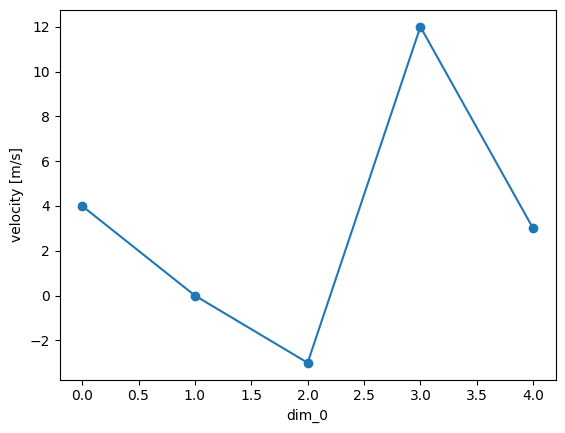

In [11]:
results = db.find_one({'$name': {'$basename': 'velocity'}}, 'dataset')

# let's directly plot the result:
results[()].plot(marker='o')

# Query using SPARQL

In [12]:
import rdflib
from h5rdmtoolbox import jsonld

In [13]:
# with h5tbx.File(h5.hdf_filename) as h52:
#     h5.dump_jsonld()

In [14]:
from ontolutils import SSNO, PIVMETA

In [15]:
with h5tbx.File() as h5:
    ds = h5.create_dataset('u', data=[1,2,3,4], attrs={'standard_name': 'coeff', 'units': 'm/s'})
    ds.rdf.predicate['standard_name'] = SSNO.hasStandardName
    ds.rdf.object['standard_name'] = PIVMETA.piv_correlation_coefficient
    h5.dump()

In [23]:
json_str = jsonld.dumps(
        h5.hdf_filename,
        indent=2,
        context={'m4i': 'http://w3id.org/nfdi4ing/metadata4ing#',
                 'foaf': 'http://xmlns.com/foaf/0.1/'}
    )
print(json_str)

{
  "@context": {
    "foaf": "http://xmlns.com/foaf/0.1/",
    "hdf5": "http://purl.allotrope.org/ontologies/hdf5/1.8#",
    "m4i": "http://w3id.org/nfdi4ing/metadata4ing#",
    "prov": "http://www.w3.org/ns/prov#",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    "schema": "https://schema.org/"
  },
  "@graph": [
    {
      "@id": "_:N1570243bffdb4d5cafbabde2aa52f37b",
      "@type": "hdf5:Group",
      "hdf5:attribute": [
        {
          "@id": "_:Ncaf3ab9975c5426388b176e91eee3abf"
        },
        {
          "@id": "_:N35246e40c119472bb9bef270d61b5387"
        },
        {
          "@id": "_:N8083ffc56044408bae611c9f620f9f0f"
        }
      ],
      "hdf5:name": "/h5rdmtoolbox",
      "schema:codeRepository": {
        "@type": "http://www.w3.org/2001/XMLSchema#anyURI",
        "@value": "https://github.com/matthiasprobst/h5RDMtoolbox"
      },
      "schema:name": "h5rdmtoolbox",
      "schema:softwareVersion": "1.2.3a1"
    },
    {
      "@id": "_:Ncaf3ab9975c5

In [29]:
sparql_query_str = """
PREFIX hdf5: <http://purl.allotrope.org/ontologies/hdf5/1.8#>
PREFIX ssno: <https://matthiasprobst.github.io/ssno#>

SELECT  ?name ?sn
{
    ?obj a hdf5:Dataset .
    ?obj hdf5:name ?name .
    ?obj ssno:hasStandardName ?sn .
}
"""

In [30]:
g = rdflib.Graph().parse(data=json_str, format='json-ld')
qres = g.query(sparql_query_str)

for name, sn in qres:
    print(str(name), str(sn))

/u https://matthiasprobst.github.io/pivmeta#piv_correlation_coefficient


Find dataset with specific standard_name:

In [88]:
def find_dataset_from_standard_name(hdf_filename, sn, limit=1):
    sparql_query_str = """
    PREFIX hdf5: <http://purl.allotrope.org/ontologies/hdf5/1.8#>
    PREFIX ssno: <https://matthiasprobst.github.io/ssno#>
    
    SELECT ?name
    {
        ?obj a hdf5:Dataset .
        ?obj hdf5:name ?name .
    """
    sparql_query_str += f"?obj ssno:hasStandardName <{sn}> .\n}}"
    g = rdflib.Graph().parse(data=json_str, format='json-ld')
    qres = g.query(sparql_query_str)

    if limit == 1:
        for name in qres:
            return str(name[0])
    else:
        return [str(name[0]) for name in qres]

In [95]:
find_dataset_from_standard_name(h5.hdf_filename, 'https://matthiasprobst.github.io/pivmeta#piv_correlation_coefficient', 1)

'/u'

In [114]:
def find_attribute_from_name(hdf_filename, name, limit=1):
    sparql_query_str = f"""
    PREFIX hdf5: <http://purl.allotrope.org/ontologies/hdf5/1.8#>
    
    SELECT  ?name
    {{
        ?obj a ?type .
        ?obj hdf5:name ?name .
        ?obj hdf5:attribute ?attr .
        ?attr hdf5:name "{name}" .
        VALUES ?type {{  hdf5:Group hdf5:Dataset }}
    }}
    """
    g = rdflib.Graph().parse(data=json_str, format='json-ld')
    qres = g.query(sparql_query_str)

    if limit == 1:
        for name in qres:
            return str(name[0])
    else:
        return [str(name[0]) for name in qres]

In [115]:
find_attribute_from_name(h5.hdf_filename, 'codeRepository', 1)

'/h5rdmtoolbox'

In [111]:
# jsonldstr = h5tbx.dump_jsonld(h5.hdf_filename)
# print(jsonldstr)

In [112]:
# g = rdflib.Graph().parse(data=jsonldstr, format='json-ld')